# import packages

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras
import tensorflow_datasets as tfds
from tensorflow.keras.layers import TextVectorization

2024-05-12 21:37:51.971413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 21:37:51.971636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 21:37:52.170223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

# Load data

In [3]:
traincsv = 'https://raw.githubusercontent.com/aimlfacnwu/MSDS_458_Fall2022/master/MSDS458_Assignment_03/data/test.csv'
valcsv = 'https://raw.githubusercontent.com/aimlfacnwu/MSDS_458_Fall2022/master/MSDS458_Assignment_03/data/val.csv'
testcsv = 'https://raw.githubusercontent.com/aimlfacnwu/MSDS_458_Fall2022/master/MSDS458_Assignment_03/data/test.csv'
train_df = pd.read_csv(traincsv)
val_df = pd.read_csv(valcsv)
test_df = pd.read_csv(testcsv)
print(f"There are {train_df.shape[0]} news articles for training.")
print(f"There are {val_df.shape[0]} news articles for validation.")
print(f"There are {test_df.shape[0]} news articles for testing.")

There are 7600 news articles for training.
There are 6000 news articles for validation.
There are 7600 news articles for testing.


In [4]:
train_df.head(2).T

,0,1
Label,2,3
Title,Fears for T N pension after talks,The Race is On: Second Private Team Sets Launc...
Description,Unions representing workers at Turner Newall...,"SPACE.com - TORONTO, Canada -- A second\team o..."
Title_Description,Fears for T N pension after talks Unions repre...,The Race is On: Second Private Team Sets Launc...


In [5]:
test_df.head(2).T

,0,1
Label,2,3
Title,Fears for T N pension after talks,The Race is On: Second Private Team Sets Launc...
Description,Unions representing workers at Turner Newall...,"SPACE.com - TORONTO, Canada -- A second\team o..."
Title_Description,Fears for T N pension after talks Unions repre...,The Race is On: Second Private Team Sets Launc...


In [6]:
allcsv= 'https://raw.githubusercontent.com/aimlfacnwu/MSDS_458_Fall2022/master/MSDS458_Assignment_03/data/all.csv'
all_df = pd.read_csv(allcsv)
all_df.shape

(127600, 4)

In [7]:
all_df.head(2).T

,0,1
Label,2,2
Title,Wall St. Bears Claw Back Into the Black (Reuters),Carlyle Looks Toward Commercial Aerospace (Reu...
Description,"Reuters - Short-sellers, Wall Street's dwindli...",Reuters - Private investment firm Carlyle Grou...
Title_Description,Wall St. Bears Claw Back Into the Black (Reute...,Carlyle Looks Toward Commercial Aerospace (Reu...


# Load CSV Datasets Convert TensorFlow Dataset

In [8]:
batch_size = 32
traincsv_file_path = tf.keras.utils.get_file("train.csv", traincsv)
valcsv_file_path = tf.keras.utils.get_file("val.csv", valcsv)
testcsv_file_path = tf.keras.utils.get_file("test.csv", testcsv)

train_ds =\
tf.data.experimental.make_csv_dataset(traincsv_file_path,select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1, batch_size=batch_size)
val_ds =\
tf.data.experimental.make_csv_dataset(valcsv_file_path,select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1,batch_size=batch_size)
test_ds =\
tf.data.experimental.make_csv_dataset(testcsv_file_path,select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1,batch_size=batch_size)

3631630/3631630 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
2872142/2872142 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
3631630/3631630 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
allcsv_file_path = tf.keras.utils.get_file("all.csv", testcsv)
all_ds =\
tf.data.experimental.make_csv_dataset(allcsv_file_path,select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1, batch_size=1)

3631630/3631630 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
text_vectorization = TextVectorization(
    output_mode="int",
)
text_only_all_ds = all_ds.map(lambda x, y: x['Title_Description'])

In [11]:
%%time
text_vectorization.adapt(text_only_all_ds)

CPU times: user 31.7 s, sys: 815 ms, total: 32.5 s
Wall time: 30.2 s


In [12]:
vocab = text_vectorization.get_vocabulary()
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 25884 vocabulary words in the corpus.


In [13]:
%%time
doc_sizes = []
corpus = []
for example, _ in all_ds:
  enc_example = text_vectorization(example['Title_Description'])
  doc_sizes.append(enc_example.shape[1])
  corpus+=list(enc_example.numpy()[0])

CPU times: user 38.1 s, sys: 578 ms, total: 38.7 s
Wall time: 37.2 s


In [14]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 283435 words in the corpus of 7600 news articles.
Each news article has between 11 and 136 tokens in it.


In [15]:
corpus[:5]

[127, 1425, 1247, 1506, 16485]

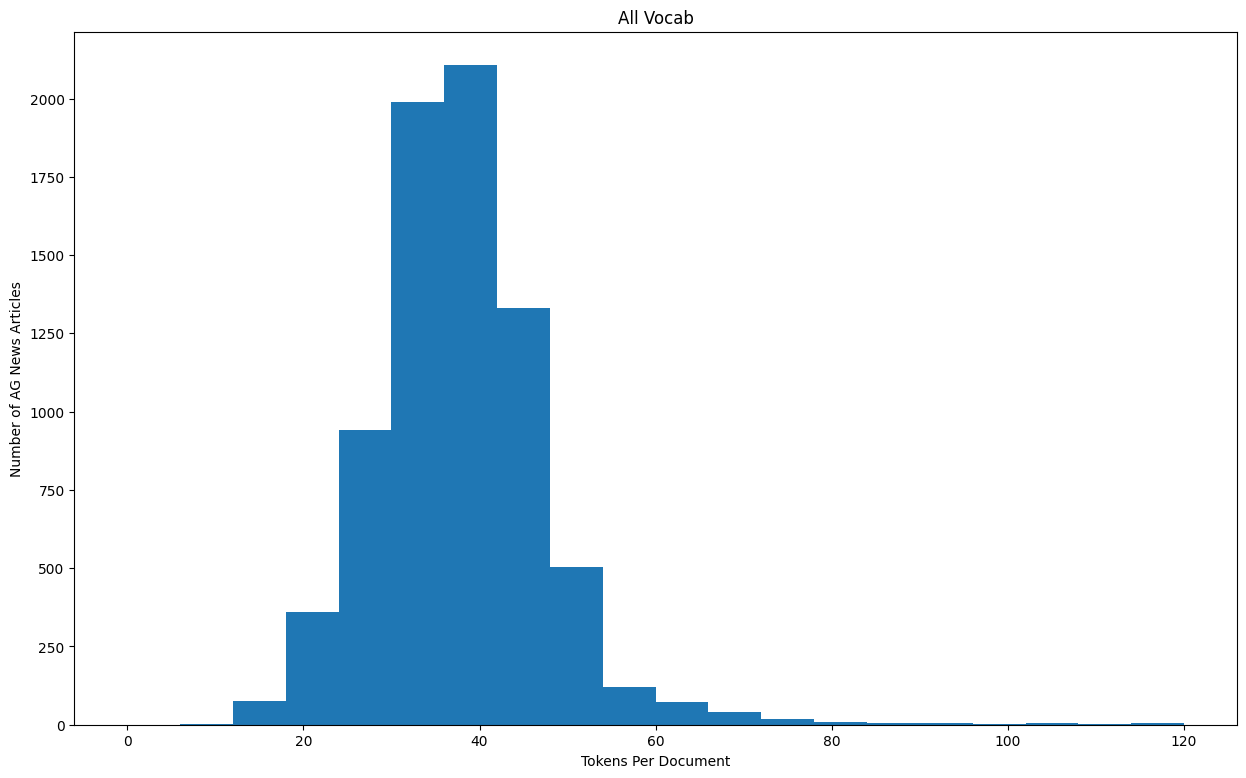

In [16]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.title("All Vocab")
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

# Experiments A: EDA:
For NLP projects, it is very important to do extensive EDA and do the preprocessing before defining models. These are the suggestions.

(a) Vocabulary Size: Tweak the vocabulary size, at least 3 levels.

In [17]:
%%time
# 100 vocab
from tensorflow.keras.layers import TextVectorization
encoder_100 = TextVectorization(
    output_mode="int",
    max_tokens=100
)
encoder_100.adapt(text_only_all_ds)
vocab_100 = np.array(encoder_100.get_vocabulary());

CPU times: user 31.4 s, sys: 795 ms, total: 32.1 s
Wall time: 29.8 s


In [18]:
%%time
doc100_sizes = []
corpus100 = []
count100=0
useless = 0
# stop = 0
percents_100 = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_100(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents_100.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  doc100_sizes.append(len(enc_example))
  corpus100 +=list(enc_example.numpy())

  count100 += tf.math.count_nonzero(enc_example>1)

CPU times: user 48.9 s, sys: 676 ms, total: 49.6 s
Wall time: 48.3 s


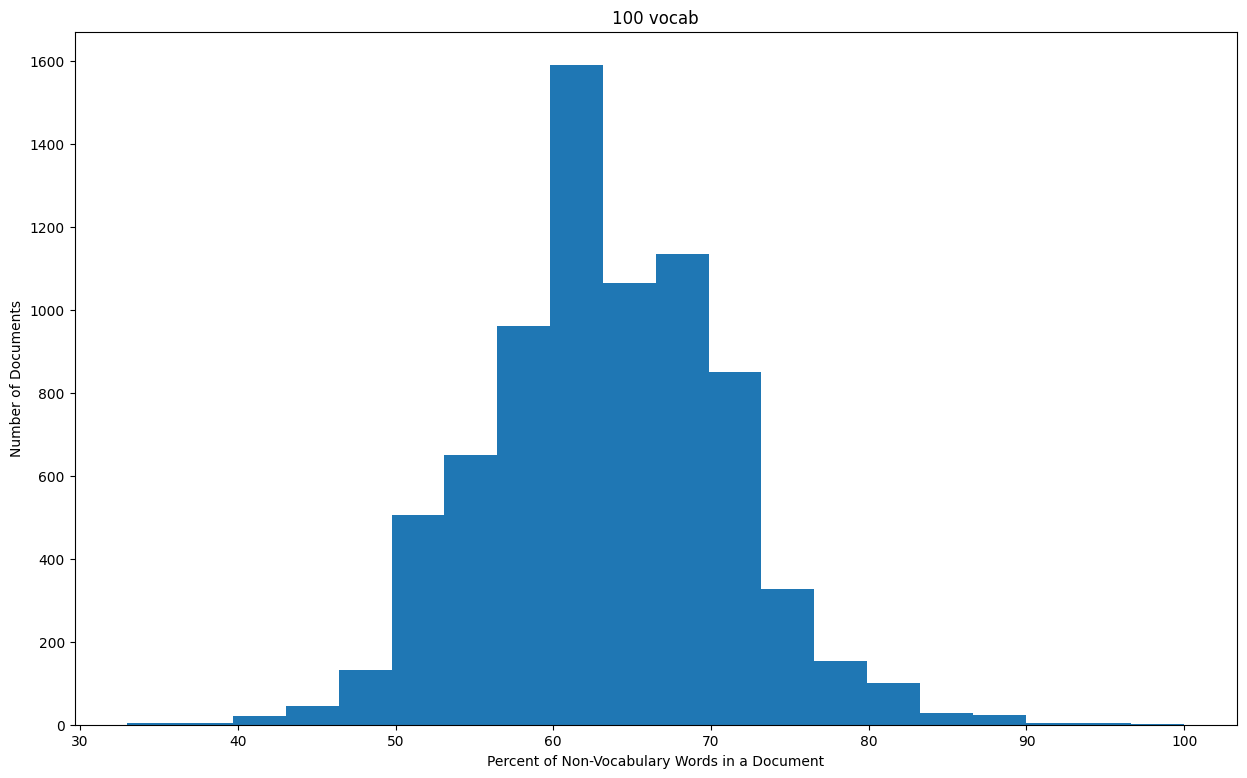

In [20]:
plt.figure(figsize=(15,9))
plt.hist(percents_100, 20)
plt.title("100 vocab")
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [22]:
# 1000 vocab
encoder_1000 = TextVectorization(
    output_mode="int",
    max_tokens=1000
)
encoder_1000.adapt(text_only_all_ds)
vocab_1000 = np.array(encoder_1000.get_vocabulary());

In [23]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents_1000 = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_1000(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents_1000.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 48.5 s, sys: 620 ms, total: 49.1 s
Wall time: 47.6 s


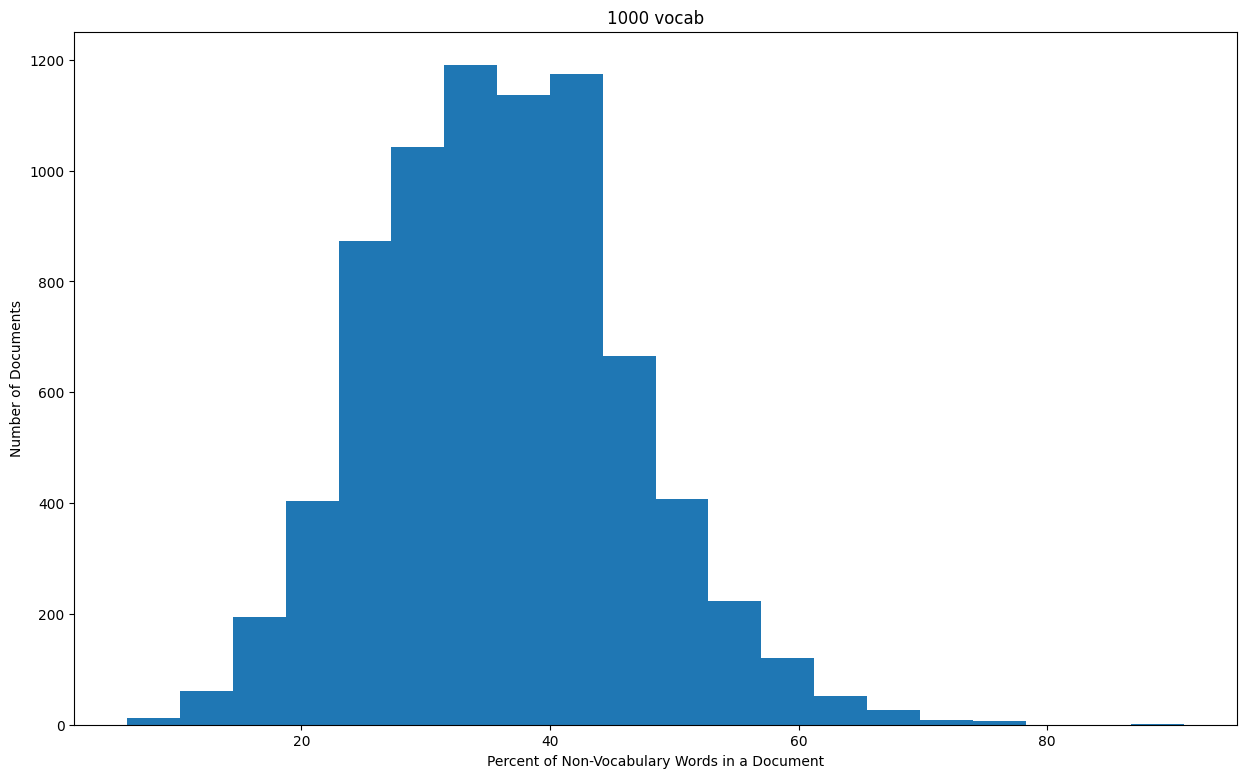

In [24]:
plt.figure(figsize=(15,9))
plt.hist(percents_1000, 20)
plt.title("1000 vocab")
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [25]:
# 10000 vocab
encoder_10k = TextVectorization(
    output_mode="int",
    max_tokens=10000
)
encoder_10k.adapt(text_only_all_ds)
vocab_10k = np.array(encoder_10k.get_vocabulary());

In [26]:
%%time
doc10k_sizes = []
corpus10k = []
count10k=0
useless = 0
# stop = 0
percents_10k = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_10k(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents_10k.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  doc10k_sizes.append(len(enc_example))
  corpus10k+=list(enc_example.numpy())

  count10k += tf.math.count_nonzero(enc_example>1)

CPU times: user 48 s, sys: 630 ms, total: 48.6 s
Wall time: 47 s


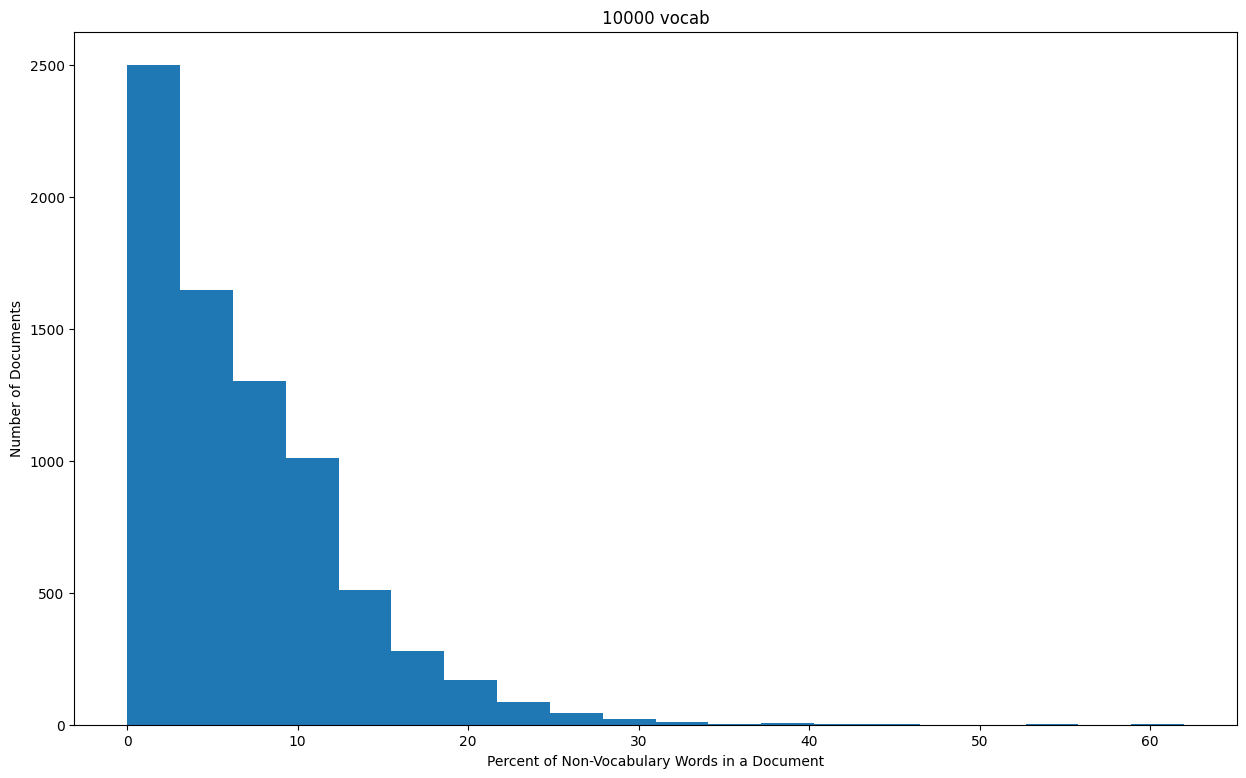

In [27]:
plt.figure(figsize=(15,9))
plt.hist(percents_10k, 20)
plt.title("10000 vocab")
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

(b) Editing the Vocabulary: Try unedited most frequent words, VERSUS edit the list by deleting the most frequent words such as article, ‘the’, ‘a’, etc.

In [33]:
stopwords = ['the', 'a', 'an', 'of', 'to', 'and', 'in', 'on', 'for', 'with']
pattern = rf"\b({'|'.join(stopwords)})\b"

vectorizer_without_stopwords = TextVectorization(max_tokens=1000, output_mode='int',
                                                 standardize=lambda x: tf.strings.regex_replace(x, pattern, ""))

vectorizer_without_stopwords.adapt(text_only_all_ds)

In [35]:
doc1000_sizes_1 = []
corpus1000_1 = []
count1000_1=0
useless = 0
# stop = 0
percents_1000_1 = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = vectorizer_without_stopwords(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents_1000_1.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  doc1000_sizes_1.append(len(enc_example))
  corpus1000_1 +=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

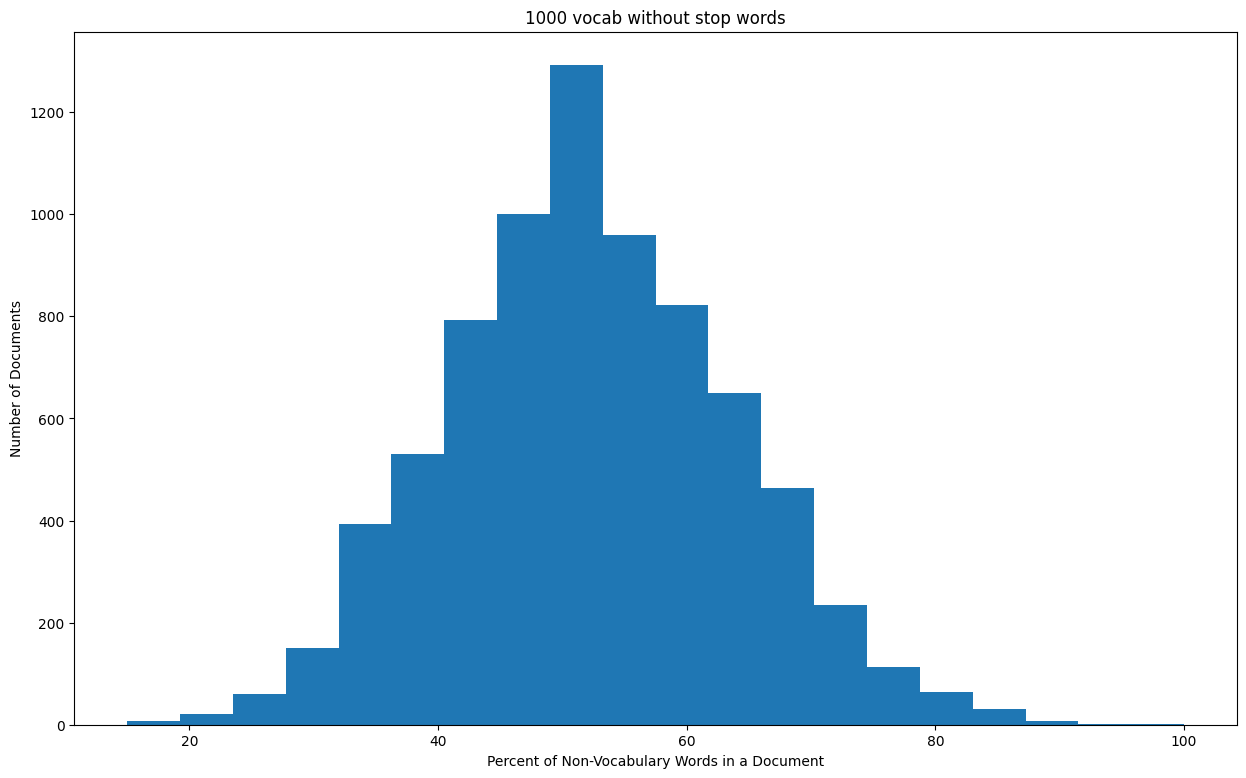

In [37]:
plt.figure(figsize=(15,9))
plt.hist(percents_1000_1, 20)
plt.title("1000 vocab without stop words")
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

(c) Output sequence length: Use the default VERSUS set it to a fixed number

In [38]:
# 1000 vocab
encoder_seq = TextVectorization(
    output_mode="int",
    max_tokens=1000,
    output_sequence_length= 150
)
encoder_seq.adapt(text_only_all_ds);

In [39]:
%%time
doc1000_sizes_seq = []
corpus1000_seq = []
count1000_seq=0
useless = 0
# stop = 0
percents_1000_seq = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_seq(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents_1000_seq.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  doc1000_sizes_seq.append(len(enc_example))
  corpus1000_seq+=list(enc_example.numpy())

  count1000_seq += tf.math.count_nonzero(enc_example>1)

CPU times: user 1min, sys: 704 ms, total: 1min 1s
Wall time: 59.8 s


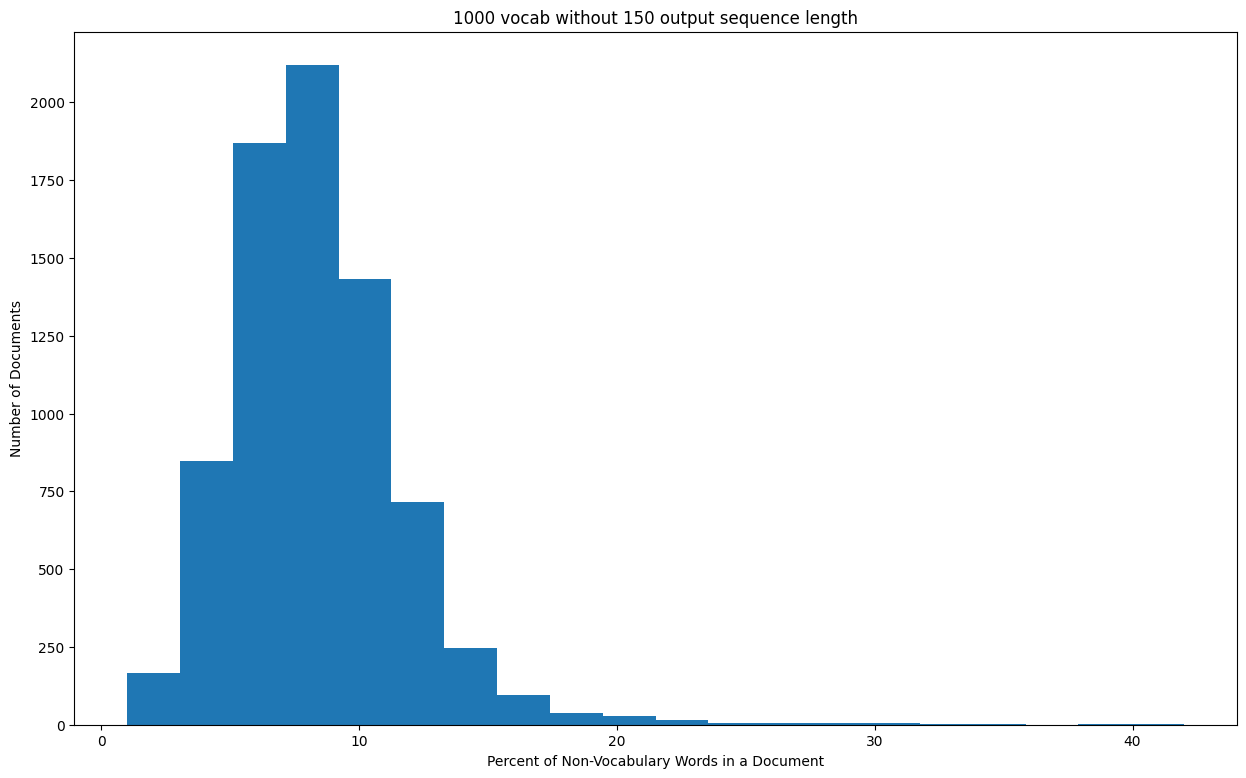

In [40]:
plt.figure(figsize=(15,9))
plt.hist(percents_1000_seq, 20)
plt.title("1000 vocab without 150 output sequence length")
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');